# In this tutorial we will build basic CNN for image classification.
Author :- Ankur Mali
* We will define our model and learn how to use keras module to build custom layers
* We will also design our own training loop, that is identical to model.fit in Keras.
* The aim of this excercise is to teach, how to use exisiting Tensorflow API to construct our own module and integrate it with tf.keras API.

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(4312)

#Things to do
* Remember to Normalize your data and create validation split from train set.
* Learn about tf.data, tf.slices and also tf.records

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_val = x_train[50000:60000]
x_train = x_train[0:50000]

y_val = y_train[50000:60000]
y_train = y_train[0:50000]

x_train = x_train.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_val = x_val.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_test = x_test.astype(np.float32).reshape(-1,28,28,1) / 255.0

y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_test = tf.one_hot(y_test, depth=10)
print(x_train.shape)
print(x_val.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
#train_dataset_full = train_dataset.shuffle(buffer_size=1024).batch(len(train_dataset))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
#val_dataset = val_dataset.batch(len(val_dataset))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#test_dataset = test_dataset.batch(len(test_dataset))


(50000, 28, 28, 1)
(10000, 28, 28, 1)


# Create your custom CNN class
* Convolution layers has 4D weights of size (h,w,input_feature, output_feature), where h=height of your kernel and w = width of our kernel. If you add batches then it is 5D.
* Now your model will convolve across your input feature map with kernel and create output feature map, that is then passed to next layer.
* As we have learned in our prior class, to initialize your weights, we use tf.Variable(weight_init(size)), tf.keras.layers.Conv2D will do this for you. Play with the function and see how it works for your problem.
* Few important concepts, learn to save your model after every k epochs and start re-training from last checkpoint. This is very useful, and you don't need to retrain your model from scratch.


In [10]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv5 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv6 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        # self.conv7 = tf.keras.layers.Conv2D(64, 1, padding='same', activation=None)
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        self.bn1=tf.keras.layers.BatchNormalization()
        self.bn2=tf.keras.layers.BatchNormalization()
        self.bn3=tf.keras.layers.BatchNormalization()
        self.bn4=tf.keras.layers.BatchNormalization()
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.acc = tf.keras.metrics.Accuracy()


    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        x = self.conv1(images)
        x= self.bn1(x,training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x= self.bn2(x,training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x= self.bn3(x,training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x= self.bn4(x,training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv8(x)
        #x = tf.nn.relu(x)
        #print(x.shape)
        x = tf.reshape(x, (-1, 1, 10))
        #x = tf.keras.layers.Flatten(x)
        return x


    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        #print(preds.shape)
        #print(target.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.trainable_variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=False)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    
    # def compute_accuracy(self, input_data):
    #     """ Compute the accuracy on the input data.
    #     """
    #     with tf.device(self.device):
    #         #acc = tf.metrics.Accuracy()
    #         for step ,(images, targets) in enumerate(input_data):
    #             # Predict the probability of each class
    #             #print(targets.shape)
    #             logits = self.predict(images, training=False)
    #             # Select the class with the highest probability
    #             #print(logits.shape)
    #             logits = tf.nn.softmax(logits)
    #             logits = tf.reshape(logits, [-1, 10])
    #             targets = tf.reshape(targets, [-1,10])
    #             preds = tf.argmax(logits, axis=1)
                
    #             #m1.update_state
    #             # Compute the accuracy
    #             #print(preds.shape)
    #             acc(tf.reshape(targets, preds))
    #     return acc

    def compute_accuracy_2(self, images, targets):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, training=False)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

  
    def fit_fc(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                training_data1 = training_data.shuffle(buffer_size=1024).batch(125)
                for step, (images, target) in enumerate(training_data1):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.trainable_variables))
                
                '''
                for i in range(len(self.variables)):
                    print(self.variables[i].name)
                print("---------------------------------------")
                for i in range(len(self.trainable_variables)):
                    print(self.trainable_variables[i].name)
                '''
                    
                # Compute the loss on the training data after one epoch
                training_data1=training_data.shuffle(buffer_size=1024).batch(125)
                for step, (images, target) in enumerate(training_data1):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                eval_data1=eval_data.shuffle(buffer_size=1024).batch(125)
                for step, (images, target) in enumerate(eval_data1):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) or ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])

                plt.plot(i + 1, self.history['train_acc'][-1], 'go-',label="Train accuracy")
                plt.plot(i + 1, self.history['val_acc'][-1], 'ro-',label="Validate accuracy")

                # Check for early stopping
                '''
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break
                '''


    def test(self, test_data):
        test_loss = tf.keras.metrics.Mean('test_loss')
        acc_test = tf.keras.metrics.Mean('test_acc')

        test_data=test_data.shuffle(buffer_size=1024).batch(125)
        for step, (images, target) in enumerate(test_data):
            loss = self.loss_fn(images, target, False)
            accuracy = self.compute_accuracy_2(images,target)
            acc_test(accuracy)
            test_loss(loss)
        print(
            f'Test Loss: {test_loss.result()}, '
            f'Test Accuracy: {acc_test.result() * 100}'
            )

In [11]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/fashion_mnist/'

# Use the GPU if available.
device = 'cpu'
#device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

Train loss at epoch 1:  1.3825884
Train Acc at epoch 1:  0.58282256
Eval loss at epoch 1:  1.3885125
Eval Acc at epoch 1:  0.5803849
Train loss at epoch 2:  0.3410016
Train Acc at epoch 2:  0.6621516
Eval loss at epoch 2:  0.37295157
Eval Acc at epoch 2:  0.7238675
Train loss at epoch 3:  0.2910465
Train Acc at epoch 3:  0.75737894
Eval loss at epoch 3:  0.3366503
Eval Acc at epoch 3:  0.7820969
Train loss at epoch 4:  0.26110256
Train Acc at epoch 4:  0.79915106
Eval loss at epoch 4:  0.31334892
Eval Acc at epoch 4:  0.8131839
Train loss at epoch 5:  0.24331285
Train Acc at epoch 5:  0.8238784
Eval loss at epoch 5:  0.30962387
Eval Acc at epoch 5:  0.83310163
Train loss at epoch 6:  0.22227664
Train Acc at epoch 6:  0.84067416
Eval loss at epoch 6:  0.29537308
Eval Acc at epoch 6:  0.84760064
Train loss at epoch 7:  0.20064104
Train Acc at epoch 7:  0.8534281
Eval loss at epoch 7:  0.2835342
Eval Acc at epoch 7:  0.8589238
Train loss at epoch 8:  0.18767193
Train Acc at epoch 8:  0.86

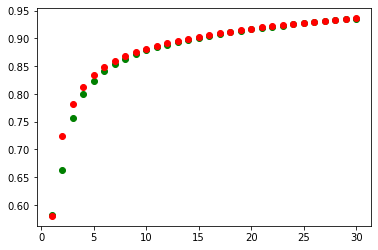

In [12]:
# Train model

model.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=30, 
          early_stopping_rounds=2, verbose=1, train_from_scratch=True)

In [13]:
model.test(test_dataset)

Test Loss: 0.34516555070877075, Test Accuracy: 93.59400939941406
